In [ ]:
## https://github.com/wizyoung/YOLOv3_TensorFlow/tree/c8c40615e0cdf00deea065fc89c3e93909c1a88a

In [2]:
cd models/research/object_detection

/home/scar3crow/Dropbox/WorkStation-Subrata/python/models/research/object_detection


In [4]:
import numpy as np
import math
import pandas as pd
import cv2
import os
import tqdm
from scipy.io import loadmat

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from PIL import Image
import pytesseract

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

from utils import *

from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import *

from keras.applications import MobileNetV2
from keras.applications import InceptionResNetV2

from keras.models import Model
from keras.models import model_from_json


In [52]:
target_size = [480, 480]
target_w = 480 # target sizes of image in model input
target_h = 480 #target sizes of image in model input

grid_size = [15, 15]
grid_y_axis = 15  # each image is to be segmented to 13 x 13 grid
grid_x_axis = 15  # # each image is to be segmented to 13 x 13 grid

grid_w = target_w / grid_x_axis  # grid cell width
grid_h = target_h / grid_y_axis  # grid cell height

channels = 3
num_anchors = 3
class_num = 5 # vendor, invoice, inv_date, po, buyer
info = 5 + class_num    # pc, x, y, h, w, and class probabilities

categories = ['vendor', 'invoice', 'inv_date', 'po', 'buyer'] # details of classes

In [8]:
def yolo_model(input_shape):
    
    
    inp = Input(input_shape)
   
    model = InceptionResNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    new_last_layer = UpSampling2D(2)(last_layer)
   #    conv = Conv2D(512,(5,5) , activation = 'relu', padding='valid')(new_last_layer)
    conv = Conv2D(512,(5,5) , padding='valid')(new_last_layer)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    another_up_layer = UpSampling2D(2)(lr)
    
#    conv = Conv2D(64,(5, 5) , activation='relu' , padding='valid')(another_up_layer)
    conv = Conv2D(64,(5, 5) , padding='valid')(another_up_layer)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
#    conv = Conv2D(128,(3,3) , activation='relu' ,strides = (2, 2), padding='valid')(lr)
    conv = Conv2D(128,(3,3) , strides = (2, 2), padding='valid')(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
  #    conv = Conv2D(30,(5, 5) , activation='relu' , padding='valid')(lr)
    conv = Conv2D(30,(5, 5) , padding='valid')(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)

    final = Reshape((grid_y_axis,grid_x_axis,num_anchors,info))(lr)
   
    model = Model(inp,final)
    
    return model


input_size = (target_w, target_h, 3)
my_yolo_invoice_model = yolo_model(input_size)

print(my_yolo_invoice_model.summary())


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 480, 480, 3)  0                                            
__________________________________________________________________________________________________
conv2d_415 (Conv2D)             (None, 239, 239, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_415 (BatchN (None, 239, 239, 32) 96          conv2d_415[0][0]                 
__________________________________________________________________________________________________
activation_407 (Activation)     (None, 239, 239, 32) 0           batch_normalization_415[0][0]    
____________________________________________________________________________________________

In [5]:
# Making a list of image path

inv_directory = '/home/scar3crow/Downloads/8-6-new-scan'  ## 'invoices' is a zip file of jpg images in ...../Downloads 
                                                        
inv_new_image = ['/home/scar3crow/Downloads/8-6-new-scan/{}'.format(i) for i in os.listdir(inv_directory)] # making the list
inv_new_image.sort() # Sorting the list

num_images = len(inv_new_image)

print('Number of images = ', num_images)
inv_new_image[24]

Number of images =  36


'/home/scar3crow/Downloads/8-6-new-scan/50a.jpg'

In [6]:
# Check sizes of exiting images & Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df_new = pd.DataFrame()

for i in range(len(inv_new_image)):
    image = cv2.imread(inv_new_image[i]) ## Loading image
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(inv_new_image[i])
    
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df_new.insert(loc=0, column='image_serial', value=image_num)
df_new.insert(loc=1, column='rows', value=row_values)
df_new.insert(loc=2, column='columns', value=col_values)

df_new.head(3)

,image_serial,rows,columns
0,/home/scar3crow/Downloads/8-6-new-scan/101a.jpg,160,416
1,/home/scar3crow/Downloads/8-6-new-scan/102a.jpg,406,870
2,/home/scar3crow/Downloads/8-6-new-scan/103a.jpg,260,416


In [7]:
# Loading output of VGG Image Annotation tool and create a dataframe

r_new_data = pd.read_csv('/home/scar3crow/Downloads/via_new_data.csv')
num_obj = r_new_data['region_count'][0] # number of objects in each photo
r_new_data.drop(r_new_data.columns[[1, 2, 3, 4]], axis=1, inplace=True) # reduce unnecessary columns
r_new_data.sort_values(by=['#filename'], ascending=True) # Sorting based on image-id
num_images = r_new_data["#filename"].nunique() # Find out number of unique images

print('Number of classes = ', num_obj)
print('Number of unique images = ', num_images)
r_new_data[58:61]

Number of classes =  5
Number of unique images =  36


,#filename,region_shape_attributes,region_attributes
58,63a.jpg,"{""name"":""rect"",""x"":211,""y"":64,""width"":76,""heig...","{""text"":""po""}"
59,63a.jpg,"{""name"":""rect"",""x"":2,""y"":68,""width"":165,""heigh...","{""text"":""buyer""}"
60,101a.jpg,"{""name"":""rect"",""x"":6,""y"":23,""width"":119,""heigh...","{""text"":""vendor""}"


In [8]:
# Making a dataframe for Image_id, x, y, width, height, class, image_width and image_height

x = []
y = []
width = []
height = []
obj_class = []
i_width = []
i_height = []
img_path = []
img_index = []

for i in range(len(r_new_data)):
    
    r_size = r_new_data.values[i, 1][1:(len(r_new_data.values[i, 1])-1)]
    r_size_par = r_size.split(",")
    
    x.append(int("".join(filter(str.isdigit, r_size_par[1]))))
    y.append(int("".join(filter(str.isdigit, r_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, r_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, r_size_par[4]))))
    
    r_attribs = r_new_data.values[i, 2][1:(len(r_new_data.values[i, 2])-1)]
    r_attribs_par = r_attribs.split(':')[1]
    obj_class.append(r_attribs_par[1:(len(r_attribs_par)-1)])
    
    foto_id = r_new_data['#filename'][i]
    i_path = '/home/scar3crow/Downloads/8-6-new-scan/' + foto_id
    foto_index = int(df_new[df_new['image_serial'] == i_path].index[0])
    foto_width = df_new['columns'][foto_index]
    foto_height = df_new['rows'][foto_index]
    i_width.append(foto_width)
    i_height.append(foto_height)
    img_path.append(i_path)
    img_index.append(foto_index)
    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
i_width_values = pd.Series(i_width)
i_height_values = pd.Series(i_height)
img_path_values = pd.Series(img_path)
img_index_values = pd.Series(img_index)

r_new_data.insert(loc=1, column='img_idx', value=img_index_values)
r_new_data.insert(loc=2, column='i_path', value=img_path_values)
r_new_data.insert(loc=3, column='x', value=x_values)
r_new_data.insert(loc=4, column='y', value=y_values)
r_new_data.insert(loc=5, column='width', value=width_values)
r_new_data.insert(loc=6, column='height', value=height_values)
r_new_data.insert(loc=7, column='obj_class', value=class_values)
r_new_data.insert(loc=8, column='img_wd', value=i_width_values)
r_new_data.insert(loc=9, column='img_ht', value=i_height_values)

r_new_data.drop(r_new_data.columns[[10, 11]], axis=1, inplace=True) # reduce unnecessary columns

r_new_data.rename({'#filename': 'img_id'}, axis=1, inplace=True) # changing column name

r_new_data[3:6]


,img_id,img_idx,i_path,x,y,width,height,obj_class,img_wd,img_ht
3,50a.jpg,24,/home/scar3crow/Downloads/8-6-new-scan/50a.jpg,221,59,103,24,po,416,209
4,50a.jpg,24,/home/scar3crow/Downloads/8-6-new-scan/50a.jpg,5,57,206,56,buyer,416,209
5,51a.jpg,25,/home/scar3crow/Downloads/8-6-new-scan/51a.jpg,5,0,120,56,vendor,416,194


In [9]:
print('Number of unique images = ', r_new_data['img_id'].nunique())  # print total no, of unique images

print('Number of classes in diff. categories = ', r_new_data['obj_class'].value_counts())

Number of unique images =  36
Number of classes in diff. categories =  buyer      38
date       36
vendor     36
invoice    36
po         33
order       1
Name: obj_class, dtype: int64


In [10]:
# We have to correct above :

# To find smallest width & height boxes in 'buyer' which should be 'po'
gb = r_new_data.groupby('obj_class')    
[gb.get_group('buyer') for x in gb.groups]


[       img_id  img_idx                                           i_path    x  \
 4     50a.jpg       24   /home/scar3crow/Downloads/8-6-new-scan/50a.jpg    5   
 9     51a.jpg       25   /home/scar3crow/Downloads/8-6-new-scan/51a.jpg    4   
 14    52a.jpg       26   /home/scar3crow/Downloads/8-6-new-scan/52a.jpg    1   
 19    53a.jpg       27   /home/scar3crow/Downloads/8-6-new-scan/53a.jpg    0   
 24    54a.jpg       28   /home/scar3crow/Downloads/8-6-new-scan/54a.jpg   31   
 29    55a.jpg       29   /home/scar3crow/Downloads/8-6-new-scan/55a.jpg    1   
 34    56a.jpg       30   /home/scar3crow/Downloads/8-6-new-scan/56a.jpg    1   
 39    59a.jpg       31   /home/scar3crow/Downloads/8-6-new-scan/59a.jpg    3   
 44    60a.jpg       32   /home/scar3crow/Downloads/8-6-new-scan/60a.jpg    0   
 49    61a.jpg       33   /home/scar3crow/Downloads/8-6-new-scan/61a.jpg    1   
 54    62a.jpg       34   /home/scar3crow/Downloads/8-6-new-scan/62a.jpg    4   
 59    63a.jpg       35   /h

In [11]:
# Correcting above wrong spelling & converting buyer to po of object classes and rechecking

id_1 = r_new_data.index[r_new_data['obj_class'] == 'order'] # Finding the index
id_2 = r_new_data.index[r_new_data['obj_class'] == 'date'] # to change 'date' to 'inv_date' to be consistent with old data

r_new_data.at[id_1, 'obj_class'] = 'po' # writing the correct spelling 
r_new_data.at[88, 'obj_class'] = 'po' # # 'buyer' to 'po'
r_new_data.at[163, 'obj_class'] = 'po' # # 'buyer' to 'po'
r_new_data.at[id_2, 'obj_class'] = 'inv_date' # # 'date' to 'inv_date'

print('Number of unique images = ', r_new_data['img_id'].nunique())  # print total no, of unique images
print('Number of unique classes = ', r_new_data['obj_class'].nunique())
print('Number of classes in diff. categories = ', r_new_data['obj_class'].value_counts())

# r_new_data.drop(r_new_data.columns[[0]], axis=1, inplace=True) # reduce unnecessary columns

r_new_data[3:6]

Number of unique images =  36
Number of unique classes =  5
Number of classes in diff. categories =  vendor      36
invoice     36
po          36
buyer       36
inv_date    36
Name: obj_class, dtype: int64


,img_id,img_idx,i_path,x,y,width,height,obj_class,img_wd,img_ht
3,50a.jpg,24,/home/scar3crow/Downloads/8-6-new-scan/50a.jpg,221,59,103,24,po,416,209
4,50a.jpg,24,/home/scar3crow/Downloads/8-6-new-scan/50a.jpg,5,57,206,56,buyer,416,209
5,51a.jpg,25,/home/scar3crow/Downloads/8-6-new-scan/51a.jpg,5,0,120,56,vendor,416,194


In [12]:
r_new_data.tail()

,img_id,img_idx,i_path,x,y,width,height,obj_class,img_wd,img_ht
175,124a.jpg,23,/home/scar3crow/Downloads/8-6-new-scan/124a.jpg,0,29,113,35,vendor,416,203
176,124a.jpg,23,/home/scar3crow/Downloads/8-6-new-scan/124a.jpg,208,73,122,14,invoice,416,203
177,124a.jpg,23,/home/scar3crow/Downloads/8-6-new-scan/124a.jpg,207,89,118,15,inv_date,416,203
178,124a.jpg,23,/home/scar3crow/Downloads/8-6-new-scan/124a.jpg,216,165,88,16,po,416,203
179,124a.jpg,23,/home/scar3crow/Downloads/8-6-new-scan/124a.jpg,1,117,190,42,buyer,416,203


In [13]:
bb = r_new_data.iat[3,1]  # 3 is row no. and 1 is col. no.
bb

24

In [14]:
## For each image, we have to find : (a) line_index = integer, (b) img_path = string, (c) boxes = shape [N, 4], 
## N is the ground truth count, elements in the second dimension are [x_min, y_min, x_max, y_max] (d) labels = shape
## [N]. class index. (e) img_width = int.  =f) img_height = int

def single_image_info(lines):
    
    ## lines will be a dataframe like, for i in range(num_images), lines = r_new_data[i*5:(i+1)*5]
    
    line_idx = lines.iat[0, 1]
    pic_path = lines.iat[0, 2]
    img_width = lines.iat[0, 8]
    img_height = lines.iat[0, 9]
    
    boxes = []
    labels = []
    for i in range(len(lines)):
        label, x_min, y_min, x_max, y_max = int(i), float(lines.iat[i,3]), float(lines.iat[i,4]), float(lines.iat[i,3]+lines.iat[i,5]), float(lines.iat[i,4]+lines.iat[i,6])
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(label)
        
    boxes = np.asarray(boxes, np.float32)
    labels = np.asarray(labels, np.int64)
    return line_idx, pic_path, boxes, labels, img_width, img_height
    
    

In [15]:
lines = pd.DataFrame()
lines = r_new_data[65:70]
lines


,img_id,img_idx,i_path,x,y,width,height,obj_class,img_wd,img_ht
65,102a.jpg,1,/home/scar3crow/Downloads/8-6-new-scan/102a.jpg,80,11,601,94,vendor,870,406
66,102a.jpg,1,/home/scar3crow/Downloads/8-6-new-scan/102a.jpg,24,304,198,30,invoice,870,406
67,102a.jpg,1,/home/scar3crow/Downloads/8-6-new-scan/102a.jpg,24,329,188,26,inv_date,870,406
68,102a.jpg,1,/home/scar3crow/Downloads/8-6-new-scan/102a.jpg,312,308,206,29,po,870,406
69,102a.jpg,1,/home/scar3crow/Downloads/8-6-new-scan/102a.jpg,431,140,307,164,buyer,870,406


In [16]:
line_idx, pic_path, boxes, labels, img_width, img_height = single_image_info(lines)

In [17]:
print('line_idx = ', line_idx)
print('picture path = ', pic_path)
print('boundary boxes = ', boxes)
print('labels = ', labels)
print('image_width = ', img_width, ' image_height = ', img_height)

line_idx =  1
picture path =  /home/scar3crow/Downloads/8-6-new-scan/102a.jpg
boundary boxes =  [[ 80.  11. 681. 105.]
 [ 24. 304. 222. 334.]
 [ 24. 329. 212. 355.]
 [312. 308. 518. 337.]
 [431. 140. 738. 304.]]
labels =  [0 1 2 3 4]
image_width =  870  image_height =  406


In [18]:

all_image_line = []
for i in range(num_images):
    image_line = []
    limit_lower = i*5
    limit_upper = limit_lower+5
    lines = r_new_data[limit_lower:limit_upper]
    line_idx, pic_path, boxes, labels, img_width, img_height = single_image_info(lines)
    image_line.append(line_idx)
    image_line.append(pic_path)
    image_line.append(boxes)
    image_line.append(labels)
    image_line.append(img_width)
    image_line.append(img_height)
    all_image_line.append(image_line)

In [19]:
print(len(all_image_line))
print(all_image_line[0])

36
[24, '/home/scar3crow/Downloads/8-6-new-scan/50a.jpg', array([[  5.,   1., 195.,  58.],
       [223.,   4., 277.,  24.],
       [323.,   4., 379.,  27.],
       [221.,  59., 324.,  83.],
       [  5.,  57., 211., 113.]], dtype=float32), array([0, 1, 2, 3, 4]), 416, 209]


In [1]:
num_bb = len(all_image_line) * len(all_image_line[0][2])
num_bb

NameError: name 'all_image_line' is not defined

In [20]:
def iou_kmeans(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou = intersection / (box_area + cluster_area - intersection)

    return iou


In [21]:
## calculating anchors from true boundary boxes :

def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]


    while True:
        for row in range(rows):
            distances[row] = 1 - iou_kmeans(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [29]:
## Finding out anchors :
## Firstly, converting true boundary box width, height to width & height with respect to grid cells :
## and then convert dimensions w.r.t. target dimensions and then devide by cell dimension finalyy find anchors


num_all_bb = len(r_new_data) # total number of boundary boxes = no. of images * 5

b_box_wrt_cells = np.zeros((num_all_bb,2))

for i in range(num_all_bb):
    
    image_w = r_new_data['img_wd'][i]
    image_h = r_new_data['img_ht'][i]

    x_ratio = target_w / image_w 
    y_ratio = target_h / image_h
    
    anchor_w = r_new_data['width'][i] * x_ratio / (target_w/grid_x_axis)
    anchor_h = r_new_data['height'][i] * y_ratio / (target_h/grid_y_axis)
    b_box_wrt_cells[i, 0] = anchor_w
    b_box_wrt_cells[i, 1] = anchor_h
    
anchors_wrt_cells= kmeans(b_box_wrt_cells, 3)

print(anchors_wrt_cells.shape)
print(anchors_wrt_cells)


(3, 2)
[[2.12740385 2.04081633]
 [5.93149038 5.01146789]
 [4.03846154 1.18518519]]


In [22]:
## Finding out anchors :
## Firstly, converting true boundary box width, height to width & height with respect to target image :
## and then convert dimensions w.r.t. target dimensions and finalyy find anchors


num_all_bb = len(r_new_data) # total number of boundary boxes = no. of images * 5

b_box_wrt_target = np.zeros((num_all_bb,2))

for i in range(num_all_bb):
    
    image_w = r_new_data['img_wd'][i]
    image_h = r_new_data['img_ht'][i]

    x_ratio = target_w / image_w 
    y_ratio = target_h / image_h
    
    anchor_w = r_new_data['width'][i] * x_ratio
    anchor_h = r_new_data['height'][i] * y_ratio
    b_box_wrt_target[i, 0] = anchor_w
    b_box_wrt_target[i, 1] = anchor_h
    
anchors_wrt_target = kmeans(b_box_wrt_target, 3)

print(anchors_wrt_target.shape)
print(anchors_wrt_target)
print(type(anchors_wrt_target))

(3, 2)
[[189.80769231 160.36697248]
 [ 68.07692308  65.30612245]
 [129.23076923  37.92592593]]
<class 'numpy.ndarray'>


In [23]:
def process_box(boxes, img_width, img_height, labels, target_size, class_num, anchors):
    '''
    Generate the y_true label, i.e. the ground truth feature_maps in 3 different scales.
    params:
        boxes: [N, 5] shape, float32 dtype. `x_min, y_min, x_max, y_mix, mixup_weight`.
        labels: [N] shape, int64 dtype.
        class_num: int64 num.
        anchors: [9, 4] shape, float32 dtype.
    '''
    anchors_mask = [[0, 1, 2]]
    
    x_ratio = target_size[1] / img_width
    y_ratio = target_size[0] / img_height
    
#    print('##################################################', x_ratio, y_ratio)
    
    # convert boxes form:
    # shape: [N, 2]
    # (x_center, y_center)
#    box_centers = (boxes[:, 0:2] + boxes[:, 2:4]) / 2  #(xmin+xmax)/2 and (ymin+ymax)/2 wrt original image

    boxes_wrt_target = np.zeros((5,4))
    box_centers_target = np.zeros((5,2))

    boxes_wrt_target[:,0] = boxes[:,0] * x_ratio
    boxes_wrt_target[:,1] = boxes[:,1] * y_ratio
    boxes_wrt_target[:,2] = boxes[:,2] * x_ratio
    boxes_wrt_target[:,3] = boxes[:,3] * y_ratio
    
#    print('###################################################', boxes_wrt_target)
    
    # expand the 2nd dimension, mix up weight default to 1.now shape of boxes_wrt_target = 5,5
    boxes_wrt_target = np.concatenate((boxes_wrt_target, np.full(shape=(boxes_wrt_target.shape[0], 1), fill_value=1., dtype=np.float32)), axis=-1)
#    print('###################################################', boxes_wrt_target)
    box_centers_target = (boxes_wrt_target[:, 0:2] + boxes_wrt_target[:, 2:4]) / 2  ## centers wrt target
    
#    print('++++++++++++++++', box_centers)
#    print('[[[[[[[[[[[[[[]]]]]]]]]]]]]]', box_centers_target)
    # (width, height)
    box_sizes = boxes[:, 2:4] - boxes[:, 0:2]  #xmax-xmin = width and ymax-ymin = height wrt original image
#    print('==============', box_sizes)
    box_sizes[:,0] = box_sizes[:,0] * x_ratio
    box_sizes[:,1] = box_sizes[:,1] * y_ratio
    

    # [13, 13, 3, 5+num_class+1] `5` means coords and labels. `1` means mix up weight. 
    y_true_13 = np.zeros((target_size[1] // 32, target_size[0] // 32, 3, 6 + class_num), np.float32)
#    y_true_26 = np.zeros((img_size[1] // 16, img_size[0] // 16, 3, 6 + class_num), np.float32)
#    y_true_52 = np.zeros((img_size[1] // 8, img_size[0] // 8, 3, 6 + class_num), np.float32)

    # mix up weight default to 1.
    y_true_13[..., -1] = 1.
    
#    print(y_true_13[1, 3, 0])
#    y_true_26[..., -1] = 1.
#    y_true_52[..., -1] = 1.

    y_true = [y_true_13]  ##, y_true_26, y_true_52]
#    print(type(y_true), len(y_true))

    # [N, 1, 2]
    box_sizes = np.expand_dims(box_sizes, 1)
#    print('+++++++++++++++++++++++++', box_sizes)
    # broadcast tricks
    # [N, 1, 2] & [9, 2] ==> [N, 9, 2]
    mins = np.maximum(- box_sizes / 2, - anchors / 2)
    maxs = np.minimum(box_sizes / 2, anchors / 2)
    # [N, 9, 2]
    whs = maxs - mins

    # [N, 9]
    iou = (whs[:, :, 0] * whs[:, :, 1]) / (
                box_sizes[:, :, 0] * box_sizes[:, :, 1] + anchors[:, 0] * anchors[:, 1] - whs[:, :, 0] * whs[:, :,
                                                                                                         1] + 1e-10)
    # [N]
    best_match_idx = np.argmax(iou, axis=1)
#    print('best_match_idx = ', best_match_idx)

#    ratio_dict = {1.: 8., 2.: 16., 3.: 32.}
    cell_size = 32  ## = targetsize / no. of grid cells
    for i, idx in enumerate(best_match_idx):
#        # idx: 0,1,2 ==> 2; 3,4,5 ==> 1; 6,7,8 ==> 0
#        print('i = ', i, ' idx = ', idx)
#       feature_map_group = 2 - idx // 3
#        print('feature_map_group = ', feature_map_group)
#        # scale ratio: 0,1,2 ==> 8; 3,4,5 ==> 16; 6,7,8 ==> 32
#        ratio = ratio_dict[np.ceil((idx + 1) / 3.)]
        x = int(np.floor(box_centers_target[i, 0] / cell_size))
        y = int(np.floor(box_centers_target[i, 1] / cell_size))
        k = int(idx)
#        k = anchors_mask[feature_map_group][idx]
        c = int(labels[i])
#        # print(feature_map_group, '|', y,x,k,c)
        print(x, y, k, c)
        
#        print( box_centers_target[i])
#
        y_true[0][y, x, k, :2] = box_centers_target[i]
        y_true[0][y, x, k, 2:4] = box_sizes[i]
        y_true[0][y, x, k, 4] = 1.
        y_true[0][y, x, k, 5 + c] = 1.
        y_true[0][y, x, k, -1] = boxes_wrt_target[i, -1]    

#    return y_true_13, y_true_26, y_true_52
#    return y_true_13, best_match_idx
    return y_true_13

In [24]:

anchors = anchors_wrt_target
 
yy_13 = process_box(boxes, img_width, img_height, labels, target_size, class_num, anchors)

2 3 2 0
9 5 2 1
9 7 2 2
9 12 2 3
3 10 0 4


In [25]:
print(yy_13[2,6,2])
print(yy_13[11,2,1])
#print(yy_13[12,2,1])
print(yy_13[11,7,1])
print(yy_13[8,10,2])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


(406, 870, 3)
80 11 681 105 44 13 375 124 vendor
24 304 222 334 13 359 122 394 invoice
24 329 212 355 13 388 116 419 inv_date
312 308 518 337 172 364 285 398 po
431 140 738 304 237 165 407 359 buyer


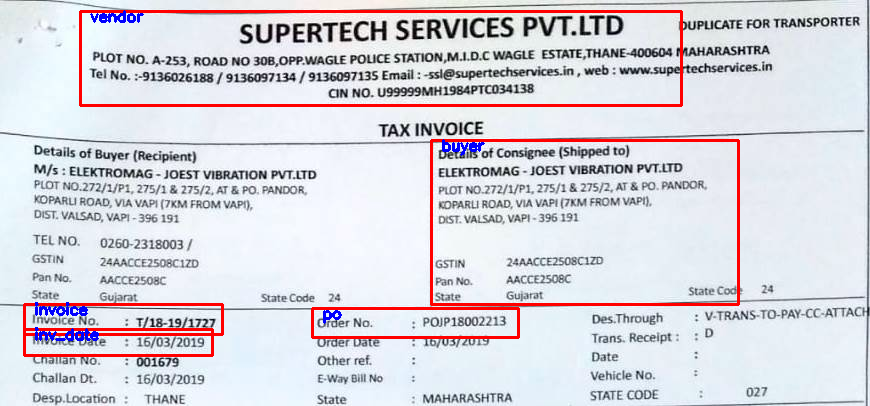

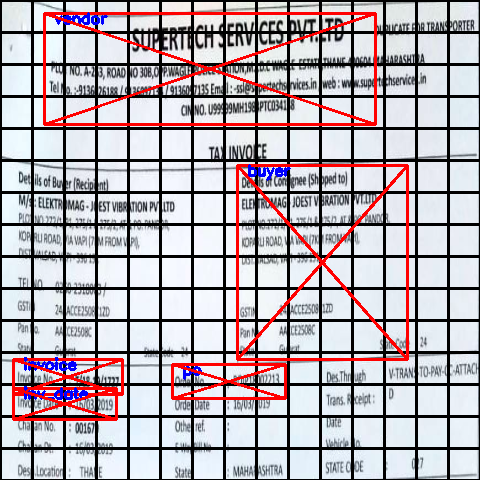

In [26]:
image_list = r_new_data['img_id'].unique() # make a list of unique images
# image_path = '/home/scar3crow/Downloads/8-6-new-scan/' + image_list[0]

image_id = '102a.jpg'
image_path = '/home/scar3crow/Downloads/8-6-new-scan/' + image_id

# to find indices for 3 
i_l_idx = [i for i in range(len(image_list)) if image_list[i] == image_id]


x = cv2.imread(image_path)
x_ratio = 480 / x.shape[1]
y_ratio = 480 / x.shape[0]
xx = cv2.resize(x,(480, 480))
print(x.shape)
r_new_data_slice = r_new_data.loc[r_new_data['img_id'].isin([image_list[i_l_idx[0]]])].reset_index(drop=True) # slicing as per current image id

m = int(480/15)
n = int(480/15)

x_range = [0, m*1, m*2, m*3, m*4, m*5, m*6, m*7, m*8, m*9, m*10, m*11, m*12, m*13, m*14]
y_range = [0, m*1, m*2, m*3, m*4, m*5, m*6, m*7, m*8, m*9, m*10, m*11, m*12, m*13, m*14]

for i in x_range:
        for j in y_range:
            cv2.rectangle(xx, (i, j), (i+32, j+32), 0, 2)



for j in range(len(r_new_data_slice)):
        
    xmin = r_new_data_slice['x'][j]
    ymin = r_new_data_slice['y'][j]
    
    xxmin = int(r_new_data_slice['x'][j]*x_ratio)
    yymin = int(r_new_data_slice['y'][j]*y_ratio)
 
    xmax = (r_new_data_slice['x'][j] + r_new_data_slice['width'][j])
    ymax = (r_new_data_slice['y'][j] + r_new_data_slice['height'][j])
    
    xxmax = int((r_new_data_slice['x'][j] + r_new_data_slice['width'][j])*x_ratio)
    yymax = int((r_new_data_slice['y'][j] + r_new_data_slice['height'][j])*y_ratio)
        
    obj_class = r_new_data_slice['obj_class'][j]
    
    print(xmin,ymin,xmax,ymax,xxmin,yymin,xxmax,yymax, obj_class)
        
    cv2.rectangle(x, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    cv2.putText(x, obj_class, (xmin+10,ymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    
    cv2.rectangle(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
    cv2.putText(xx, obj_class, (xxmin+10,yymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    cv2.line(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
    cv2.line(xx, (xxmin, yymax), (xxmax, yymin), (255, 0, 0), 2)
        
    
x_pil = Image.fromarray(x)
display(x_pil)

xx_pil = Image.fromarray(xx)
display(xx_pil)

In [27]:
def parse_data(line, class_num, target_size, anchors):   ## (mode, letterbox_resize):
    '''
    param:
        line: a line from the training/test txt file
        class_num: totol class nums.
        target_size: the size of image to be resized to. [width, height] format.
        anchors: anchors.
        mode: 'train' or 'val'. When set to 'train', data_augmentation will be applied.
        letterbox_resize: whether to use the letterbox resize, i.e., keep the original aspect ratio in the resized image.
    '''
    
    img_idx, pic_path, boxes, labels,img_width, img_height = line
    img = cv2.imread(pic_path)
    img_resized = cv2.resize(img,(target_size[0], target_size[1]))
    
    # expand the 2nd dimension, mix up weight default to 1.
    boxes = np.concatenate((boxes, np.full(shape=(boxes.shape[0], 1), fill_value=1., dtype=np.float32)), axis=-1)
    
    
#    img, boxes = resize_with_bbox(img, boxes, img_size[0], img_size[1], interp=1, letterbox=letterbox_resize)

    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB).astype(np.float32)

    # the input of yolo_v3 should be in range 0~1
    img_resized = img_resized / 255.

    y_true_13 = process_box(boxes, img_width, img_height, labels, target_size, class_num, anchors)

    return img_idx, img_resized, y_true_13


In [28]:
## Making the data ready for entering into network :

anchors = anchors_wrt_target
image_index = []
image_resized = []
image_y_true = []

for i in range(len(all_image_line)):
    line = all_image_line[i]
    
    img_idx, img_resized, y_true = parse_data(line, class_num, target_size, anchors)
    image_index.append(img_idx)
    image_resized.append(img_resized)
    image_y_true.append(y_true)

3 2 0 0
9 1 1 1
12 1 1 2
9 5 2 3
3 6 0 4
2 2 0 0
9 0 1 1
12 0 1 2
9 4 1 3
2 6 0 4
3 2 0 0
9 1 1 1
12 1 1 2
9 5 1 3
2 6 0 4
3 2 0 0
9 0 1 1
12 0 1 2
10 5 1 3
3 6 0 4
7 3 0 0
10 9 2 1
11 11 2 2
11 12 2 3
4 11 0 4
2 3 0 0
9 1 1 1
12 1 1 2
10 7 1 3
3 9 0 4
2 3 0 0
9 1 1 1
12 1 1 2
10 7 1 3
3 10 0 4
2 2 0 0
9 0 1 1
12 0 1 2
9 3 1 3
3 6 0 4
2 3 0 0
9 1 1 1
12 1 1 2
10 8 1 3
2 9 0 4
2 3 0 0
8 1 1 1
12 1 1 2
9 7 1 3
2 10 0 4
2 3 0 0
9 1 1 1
12 1 1 2
9 8 1 3
3 10 0 4
2 2 0 0
8 1 1 1
12 1 1 2
8 6 1 3
3 7 0 4
2 4 0 0
9 3 1 1
12 2 1 2
10 7 1 3
2 8 0 4
6 2 0 0
2 11 2 1
2 12 2 2
7 11 2 3
10 8 0 4
3 6 0 0
9 5 1 1
12 5 1 2
9 8 2 3
3 9 0 4
11 4 0 0
9 9 2 1
13 9 2 2
9 12 2 3
3 12 0 4
2 2 0 0
9 1 1 1
12 1 1 2
9 6 1 3
2 9 0 4
2 2 0 0
9 2 1 1
12 2 1 2
9 8 1 3
2 9 0 4
2 2 0 0
9 1 1 1
12 2 1 2
10 7 1 3
2 7 0 4
5 2 0 0
2 5 2 1
2 4 2 2
2 7 2 3
10 12 0 4
5 1 0 0
2 4 2 1
2 4 2 2
2 6 2 3
10 12 0 4
7 5 0 0
10 10 2 1
10 11 2 2
11 13 2 3
4 12 0 4
11 3 0 0
9 9 1 1
13 9 2 2
10 12 2 3
4 11 0 4
3 2 0 0
9 1 1 1
12 1 1 2


In [29]:
print(len(image_index), len(image_resized), len(image_y_true), len(all_image_line))
print(image_index[0], image_resized[0].shape, image_y_true[0].shape)

36 36 36 36
24 (480, 480, 3) (15, 15, 3, 11)


In [141]:
def yolo_block(inputs, filters):
    net = Conv2D(inputs, filters * 1, 1)
    net = Conv2D(net, filters * 2, 3)
    net = Conv2D(net, filters * 1, 1)
    net = Conv2D(net, filters * 2, 3)
    net = Conv2D(net, filters * 1, 1)
    route = net
    net = Conv2D(net, filters * 2, 3)
    return route, net


In [142]:
input_size = (target_w, target_h, 3) 
my_m_1, my_m_2 = yolo_block(input_size, 3)

/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D((480, 480,..., (3, 1))`
  
/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(<keras.lay..., (6, 3))`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(<keras.lay..., (3, 1))`
  after removing the cwd from sys.path.
/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(<keras.lay..., (6, 3))`
  """
/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/pyth

In [144]:
my_m_1.summary()

AttributeError: 'Conv2D' object has no attribute 'summary'

In [30]:
slim = tf.contrib.slim

def conv2d(inputs, filters, kernel_size, strides=1):
    def _fixed_padding(inputs, kernel_size):
        pad_total = kernel_size - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg

        padded_inputs = tf.pad(inputs, [[0, 0], [pad_beg, pad_end],
                                        [pad_beg, pad_end], [0, 0]], mode='CONSTANT')
        return padded_inputs
    if strides > 1: 
        inputs = _fixed_padding(inputs, kernel_size)
    inputs = slim.conv2d(inputs, filters, kernel_size, stride=strides,
                         padding=('SAME' if strides == 1 else 'VALID'))
    return inputs

def darknet53_body(inputs):
    def res_block(inputs, filters):
        shortcut = inputs
        net = conv2d(inputs, filters * 1, 1)
        net = conv2d(net, filters * 2, 3)

        net = net + shortcut

        return net
    
    # first two conv2d layers
    net = conv2d(inputs, 32,  3, strides=1)
    net = conv2d(net, 64,  3, strides=2)

    # res_block * 1
    net = res_block(net, 32)

    net = conv2d(net, 128, 3, strides=2)

    # res_block * 2
    for i in range(2):
        net = res_block(net, 64)

    net = conv2d(net, 256, 3, strides=2)

    # res_block * 8
    for i in range(8):
        net = res_block(net, 128)

    route_1 = net
    net = conv2d(net, 512, 3, strides=2)

    # res_block * 8
    for i in range(8):
        net = res_block(net, 256)

    route_2 = net
    net = conv2d(net, 1024, 3, strides=2)

    # res_block * 4
    for i in range(4):
        net = res_block(net, 512)
    route_3 = net

    return route_1, route_2, route_3


def yolo_block(inputs, filters):
    net = conv2d(inputs, filters * 1, 1)
    net = conv2d(net, filters * 2, 3)
    net = conv2d(net, filters * 1, 1)
    net = conv2d(net, filters * 2, 3)
    net = conv2d(net, filters * 1, 1)
    route = net
    net = conv2d(net, filters * 2, 3)
    return route, net


def upsample_layer(inputs, out_shape):
    new_height, new_width = out_shape[1], out_shape[2]
    # NOTE: here height is the first
    # TODO: Do we need to set `align_corners` as True?
    inputs = tf.image.resize_nearest_neighbor(inputs, (new_height, new_width), name='upsampled')
    return inputs

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [31]:
class yolov3(object):

    def __init__(self, class_num, anchors, use_label_smooth=False, use_focal_loss=False, batch_norm_decay=0.999, weight_decay=5e-4, use_static_shape=True):

        # self.anchors = [[10, 13], [16, 30], [33, 23],
                         # [30, 61], [62, 45], [59,  119],
                         # [116, 90], [156, 198], [373,326]]
        self.class_num = class_num
        self.anchors = anchors
        self.batch_norm_decay = batch_norm_decay
        self.use_label_smooth = use_label_smooth
        self.use_focal_loss = use_focal_loss
        self.weight_decay = weight_decay
        # inference speed optimization
        # if `use_static_shape` is True, use tensor.get_shape(), otherwise use tf.shape(tensor)
        # static_shape is slightly faster
        self.use_static_shape = use_static_shape

    def forward(self, inputs, is_training=False, reuse=False):
    
        # the input img_size, form: [height, weight]
        
        # it will be used later
        self.img_size = tf.shape(inputs)[1:3]
        # set batch norm params
        batch_norm_params = {
            'decay': self.batch_norm_decay,
            'epsilon': 1e-05,
            'scale': True,
            'is_training': is_training,
            'fused': None,  # Use fused batch norm if possible.
        }

        with slim.arg_scope([slim.conv2d, slim.batch_norm], reuse=reuse):
        
            with slim.arg_scope([slim.conv2d], 
                                normalizer_fn=slim.batch_norm,
                                normalizer_params=batch_norm_params,
                                biases_initializer=None,
                                activation_fn=lambda x: tf.nn.leaky_relu(x, alpha=0.1),
                                weights_regularizer=slim.l2_regularizer(self.weight_decay)):
                with tf.variable_scope('darknet53_body'):
                    route_1, route_2, route_3 = darknet53_body(inputs)

                with tf.variable_scope('yolov3_head'):
                    inter1, net = yolo_block(route_3, 512)
                    feature_map_1 = slim.conv2d(net, 3 * (5 + self.class_num), 1,
                                                stride=1, normalizer_fn=None,
                                                activation_fn=None, biases_initializer=tf.zeros_initializer())
                    feature_map_1 = tf.identity(feature_map_1, name='feature_map_1')

                    inter1 = conv2d(inter1, 256, 1)
                    inter1 = upsample_layer(inter1, route_2.get_shape().as_list() if self.use_static_shape else tf.shape(route_2))
                    concat1 = tf.concat([inter1, route_2], axis=3)

                    inter2, net = yolo_block(concat1, 256)
                    feature_map_2 = slim.conv2d(net, 3 * (5 + self.class_num), 1,
                                                stride=1, normalizer_fn=None,
                                                activation_fn=None, biases_initializer=tf.zeros_initializer())
                    feature_map_2 = tf.identity(feature_map_2, name='feature_map_2')

                    inter2 = conv2d(inter2, 128, 1)
                    inter2 = upsample_layer(inter2, route_1.get_shape().as_list() if self.use_static_shape else tf.shape(route_1))
                    concat2 = tf.concat([inter2, route_1], axis=3)

                    _, feature_map_3 = yolo_block(concat2, 128)
                    feature_map_3 = slim.conv2d(feature_map_3, 3 * (5 + self.class_num), 1,
                                                stride=1, normalizer_fn=None,
                                                activation_fn=None, biases_initializer=tf.zeros_initializer())
                    feature_map_3 = tf.identity(feature_map_3, name='feature_map_3')

            return feature_map_1, feature_map_2, feature_map_3


In [32]:
anchors = anchors_wrt_target
yolo_model= yolov3(5, anchors,use_static_shape=False)

In [60]:
yolo_model

In [33]:
image = np.array((image_resized))
pred_feature_maps = yolo_model.forward(image, is_training=False)
feature_map_1, feature_map_2, feature_map_3 = yolo_model.forward(image, is_training=False)

ValueError: Variable darknet53_body/Conv/weights already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 283, in variable
    aggregation=aggregation)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 355, in model_variable
    aggregation=aggregation)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1752, in _model_variable_getter
    aggregation=aggregation)


In [36]:
pred_feature_maps[0]

<tf.Tensor 'yolov3_head/feature_map_1:0' shape=(36, 15, 15, 30) dtype=float32>

In [40]:
feature_map_1 = Reshape((grid_y_axis,grid_x_axis,num_anchors,info))(pred_feature_maps[0])

In [61]:
feature_map_1

<tf.Tensor 'reshape_2/Reshape:0' shape=(36, 15, 15, 3, 10) dtype=float32>

In [56]:
feature_map_1.shape

TensorShape([Dimension(36), Dimension(15), Dimension(15), Dimension(3), Dimension(10)])

In [46]:
with tf.Session() as sess:  print(feature_map_1.eval()) 


FailedPreconditionError: Attempting to use uninitialized value yolov3_head/Conv_3/BatchNorm/moving_mean
	 [[node yolov3_head/Conv_3/BatchNorm/moving_mean/read (defined at <ipython-input-30-59781cfdf699>:15) ]]

Original stack trace for 'yolov3_head/Conv_3/BatchNorm/moving_mean/read':
  File "/usr/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 413, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1394, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 126, in _run
    self._callback(*self._args)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-2c02aa433c40>", line 2, in <module>
    pred_feature_maps = yolo_model.forward(image, is_training=False)
  File "<ipython-input-31-415b1b092082>", line 46, in forward
    inter1, net = yolo_block(route_3, 512)
  File "<ipython-input-30-59781cfdf699>", line 69, in yolo_block
    net = conv2d(net, filters * 2, 3)
  File "<ipython-input-30-59781cfdf699>", line 15, in conv2d
    padding=('SAME' if strides == 1 else 'VALID'))
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1159, in convolution2d
    conv_dims=2)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1066, in convolution
    outputs = normalizer_fn(outputs, **normalizer_params)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 650, in batch_norm
    outputs = layer.apply(inputs, training=is_training)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1479, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 537, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/keras/engine/base_layer.py", line 591, in __call__
    self._maybe_build(inputs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1881, in _maybe_build
    self.build(input_shapes)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/keras/layers/normalization.py", line 396, in build
    experimental_autocast=False)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 450, in add_weight
    **kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/keras/engine/base_layer.py", line 384, in add_weight
    aggregation=aggregation)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/training/tracking/base.py", line 663, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 1496, in get_variable
    aggregation=aggregation)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 1239, in get_variable
    aggregation=aggregation)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 545, in get_variable
    return custom_getter(**custom_getter_kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 1955, in wrapped_custom_getter
    return custom_getter(functools.partial(old_getter, getter), *args, **kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1761, in layer_variable_getter
    return _model_variable_getter(getter, *args, **kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1752, in _model_variable_getter
    aggregation=aggregation)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 355, in model_variable
    aggregation=aggregation)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 283, in variable
    aggregation=aggregation)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1761, in layer_variable_getter
    return _model_variable_getter(getter, *args, **kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1752, in _model_variable_getter
    aggregation=aggregation)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 355, in model_variable
    aggregation=aggregation)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 283, in variable
    aggregation=aggregation)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 514, in _true_getter
    aggregation=aggregation)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 929, in _get_single_variable
    aggregation=aggregation)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 2511, in default_variable_creator
    shape=shape)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 1568, in __init__
    shape=shape)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 1755, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 86, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4253, in identity
    "Identity", input=input, name=name)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [163]:
#x = np.ones((36,15,15,3,10))
x = np.random.rand(2, 2, 4, 9)
print(x.shape)
xx = np.reshape(x, [2,2,4, 3, 3])
xx

(2, 2, 4, 9)


array([[[[[0.26320224, 0.56851882, 0.50673387],
          [0.40183826, 0.43378975, 0.17181986],
          [0.55215431, 0.60773539, 0.51578914]],

         [[0.50116755, 0.70410621, 0.20863586],
          [0.81204352, 0.6407155 , 0.36636368],
          [0.9429473 , 0.07663363, 0.58664224]],

         [[0.74283038, 0.05060893, 0.25176894],
          [0.39838119, 0.75327507, 0.28265309],
          [0.66109487, 0.54528249, 0.45947896]],

         [[0.53584363, 0.54027642, 0.58269117],
          [0.77694571, 0.96727649, 0.86788151],
          [0.64242158, 0.9736133 , 0.35412078]]],


        [[[0.74004763, 0.78937932, 0.68992213],
          [0.09622371, 0.36418403, 0.730589  ],
          [0.60263985, 0.58584193, 0.38648491]],

         [[0.13326279, 0.56956638, 0.55883238],
          [0.40377024, 0.08389711, 0.3482452 ],
          [0.77996806, 0.45715802, 0.84677148]],

         [[0.92423299, 0.92599935, 0.21663102],
          [0.44608502, 0.67092775, 0.3793516 ],
          [0.43074487, 0.1

In [142]:
x[0]

array([0.28797583, 0.76091639, 0.39891842, 0.78084167, 0.18713136,
       0.79627442, 0.96578312, 0.03308083, 0.94562542])

In [188]:
a, b, c,g = np.split(x, [2,4, 5], axis = -1)
d, e ,f = np.split(xx,[1, 2], axis =-1 )

In [192]:
print(g.shape)
g

(2, 2, 4, 4)


array([[[[0.17181986, 0.55215431, 0.60773539, 0.51578914],
         [0.36636368, 0.9429473 , 0.07663363, 0.58664224],
         [0.28265309, 0.66109487, 0.54528249, 0.45947896],
         [0.86788151, 0.64242158, 0.9736133 , 0.35412078]],

        [[0.730589  , 0.60263985, 0.58584193, 0.38648491],
         [0.3482452 , 0.77996806, 0.45715802, 0.84677148],
         [0.3793516 , 0.43074487, 0.16164277, 0.21726073],
         [0.9954426 , 0.13170421, 0.4004133 , 0.04077337]]],


       [[[0.55715667, 0.50114759, 0.51241519, 0.14683154],
         [0.79647394, 0.84770668, 0.94409141, 0.50026673],
         [0.36976731, 0.01864914, 0.68273992, 0.87471049],
         [0.38632321, 0.122858  , 0.89726153, 0.59851886]],

        [[0.80371433, 0.45574532, 0.92084407, 0.67606604],
         [0.05519689, 0.47050152, 0.2072387 , 0.96998199],
         [0.15440845, 0.8636265 , 0.50948157, 0.1093618 ],
         [0.0599181 , 0.95384678, 0.85705916, 0.05125556]]]])

In [166]:
x

array([[[[0.26320224, 0.56851882, 0.50673387, 0.40183826, 0.43378975,
          0.17181986, 0.55215431, 0.60773539, 0.51578914],
         [0.50116755, 0.70410621, 0.20863586, 0.81204352, 0.6407155 ,
          0.36636368, 0.9429473 , 0.07663363, 0.58664224],
         [0.74283038, 0.05060893, 0.25176894, 0.39838119, 0.75327507,
          0.28265309, 0.66109487, 0.54528249, 0.45947896],
         [0.53584363, 0.54027642, 0.58269117, 0.77694571, 0.96727649,
          0.86788151, 0.64242158, 0.9736133 , 0.35412078]],

        [[0.74004763, 0.78937932, 0.68992213, 0.09622371, 0.36418403,
          0.730589  , 0.60263985, 0.58584193, 0.38648491],
         [0.13326279, 0.56956638, 0.55883238, 0.40377024, 0.08389711,
          0.3482452 , 0.77996806, 0.45715802, 0.84677148],
         [0.92423299, 0.92599935, 0.21663102, 0.44608502, 0.67092775,
          0.3793516 , 0.43074487, 0.16164277, 0.21726073],
         [0.22833058, 0.49751128, 0.37387635, 0.02700188, 0.47447525,
          0.9954426 , 0.1

In [97]:
feature_map_1 = np.random.rand(36,15,15,30)

In [201]:
def my_sigmoid(x):
    result = 1/(1 + np.exp(-x))
    return result

In [234]:

def reorg_layer(feature_map, anchors):
    
    # feature_map : feature maps of shape: [N, 15, 15, 3*(5 + num_class)] i.e. N, 15, 15, 30
    # anchors: shape: [3, 2]
    
    grid_size = [15, 15]
    ratio = 480/15      ## ratio = 32

# make anchors w.r.t. grid cells :
    rescaled_anchors = anchors / ratio   # rescaled_anchors = anchors_wrt_cell
    feature_map_1 = np.reshape(feature_map_1, [-1, grid_size[0], grid_size[1], 3, info])
    print(feature_map_1.shape)
    box_centers, box_sizes, conf_logits, prob_logits = np.split(feature_map_1, [2, 4, class_num], axis=-1)
    box_centers = my_sigmoid(box_centers)
    print(box_centers.shape)
    print(box_centers[35, 10, 3])

#grid_x = tf.range(grid_size[1], dtype=tf.int32)
    grid_x = np.arange(grid_size[1])
#grid_x, grid_y = grid_size
#grid_y = tf.range(grid_size[0], dtype=tf.int32)
    grid_y = np.arange(grid_size[0])
#grid_x, grid_y = tf.meshgrid(grid_x, grid_y)
    print('grid_x', grid_x, 'grid_y', grid_y)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    print('grid_x', grid_x, 'grid_y', grid_y)

#x_offset = tf.reshape(grid_x, (-1, 1))
    x_offset = np.reshape(grid_x, (-1, 1))
#y_offset = tf.reshape(grid_y, (-1, 1))
    y_offset = np.reshape(grid_y, (-1, 1))
    x_y_offset = np.concatenate([x_offset, y_offset], axis=-1)

    print('===========================================================================')

#print(x_y_offset)
    print(x_y_offset.shape)

# shape: [13, 13, 1, 2]
    x_y_offset = np.reshape(x_y_offset, [grid_size[0], grid_size[1], 1, 2])
    print(x_y_offset.shape)
      
# get the absolute box coordinates on the feature_map 
    box_centers = box_centers + x_y_offset  ## initially to get the box centers wrt grid_cell, we had subtracted grid
                                        # number to get values in 0-1 scale. Here, we are adding back the grid no.
    print(box_centers.shape)
    print(box_centers[35, 10, 3])
        # rescale to the original image scale
    box_centers = box_centers * ratio

        # avoid getting possible nan value with tf.clip_by_value
    box_sizes = np.exp(box_sizes) * rescaled_anchors
        # box_sizes = tf.clip_by_value(tf.exp(box_sizes), 1e-9, 100) * rescaled_anchors
        # rescale to the original image scale
    box_sizes = box_sizes * ratio

        # shape: [N, 13, 13, 3, 4]
        # last dimension: (center_x, center_y, w, h)
    boxes = np.concatenate([box_centers, box_sizes], axis=-1)

        # shape:
        # x_y_offset: [13, 13, 1, 2]
        # boxes: [N, 13, 13, 3, 4], rescaled to the original image scale
        # conf_logits: [N, 13, 13, 3, 1]
        # prob_logits: [N, 13, 13, 3, class_num]
    return x_y_offset, boxes, conf_logits, prob_logits

In [197]:
prob_logits.shape

(36, 15, 15, 3, 5)

In [242]:
def predict(feature_map, anchors):
        '''
        Receive the returned feature_maps from `forward` function,
        the produce the output predictions at the test stage.
        '''
        # feature_map_1, feature_map_2, feature_map_3 = feature_maps

        # feature_map_anchors = [(feature_map_1, self.anchors[6:9]),
        #                       (feature_map_2, self.anchors[3:6]),
        #                       (feature_map_3, self.anchors[0:3])]
        
        x_y_offset, boxes, conf_logits, prob_logits = reorg_layer(feature_map, anchors)

        boxes_list, confs_list, probs_list = [], [], []
        
        
        confs = my_sigmoid(conf_logits)
        probs = my_sigmoid(prob_logits)
#        boxes_list.append(boxes)
#        confs_list.append(confs)
#        probs_list.append(probs)
        
        # collect results on three scales
        # take 416*416 input image for example:
        # shape: [N, (13*13+26*26+52*52)*3, 4]
#        boxes = tf.concat(boxes_list, axis=1)
        # shape: [N, (13*13+26*26+52*52)*3, 1]
#        confs = tf.concat(confs_list, axis=1)
        # shape: [N, (13*13+26*26+52*52)*3, class_num]
#        probs = tf.concat(probs_list, axis=1)

        center_x, center_y, width, height = np.split(boxes, [1, 2, 3], axis=-1)
        x_min = center_x - width / 2
        y_min = center_y - height / 2
        x_max = center_x + width / 2
        y_max = center_y + height / 2

        boxes = tf.concat([x_min, y_min, x_max, y_max], axis=-1)

        return boxes, confs, probs


In [244]:
def box_iou(self, pred_boxes, valid_true_boxes):
        '''
        param:
            pred_boxes: [13, 13, 3, 4], (center_x, center_y, w, h)
            valid_true: [V, 4]
        '''

        # [13, 13, 3, 2]
        pred_box_xy = pred_boxes[..., 0:2]
        pred_box_wh = pred_boxes[..., 2:4]

        # shape: [13, 13, 3, 1, 2]
        pred_box_xy = np.expand_dims(pred_box_xy, -2)
        pred_box_wh = np.expand_dims(pred_box_wh, -2)

        # [V, 2]
        true_box_xy = valid_true_boxes[:, 0:2]
        true_box_wh = valid_true_boxes[:, 2:4]

        # [13, 13, 3, 1, 2] & [V, 2] ==> [13, 13, 3, V, 2]
        intersect_mins = np.maximum(pred_box_xy - pred_box_wh / 2.,
                                    true_box_xy - true_box_wh / 2.)
        intersect_maxs = np.minimum(pred_box_xy + pred_box_wh / 2.,
                                    true_box_xy + true_box_wh / 2.)
        intersect_wh = np.maximum(intersect_maxs - intersect_mins, 0.)

        # shape: [13, 13, 3, V]
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        # shape: [13, 13, 3, 1]
        pred_box_area = pred_box_wh[..., 0] * pred_box_wh[..., 1]
        # shape: [V]
        true_box_area = true_box_wh[..., 0] * true_box_wh[..., 1]
        # shape: [1, V]
        true_box_area = np.expand_dims(true_box_area, axis=0)

        # [13, 13, 3, V]
        iou = intersect_area / (pred_box_area + true_box_area - intersect_area + 1e-10)

        return iou

In [245]:

    def loss_layer(self, feature_map, y_true, anchors):
        '''
        calc loss function from a certain scale
        input:
            feature_map_i: feature maps of a certain scale. shape: [N, 13, 13, 3*(5 + num_class)] etc.
            y_true: y_ture from a certain scale. shape: [N, 13, 13, 3, 5 + num_class + 1] etc.
            anchors: shape [9, 2]
        '''
        
        # size in [h, w] format! don't get messed up!
        grid_size = [15, 15]
        
        # the downscale ratio in height and weight
        ratio = 480/15      ## ratio = 32
        
        # N: batch_size
        N = feature_map.shape[0]

        x_y_offset, pred_boxes, pred_conf_logits, pred_prob_logits = reorg_layer(feature_map, anchors)

        ###########
        # get mask
        ###########

        # shape: take 416x416 input image and 13*13 feature_map for example:
        # [N, 13, 13, 3, 1]
        object_mask = y_true[..., 4:5]

        # the calculation of ignore mask if referred from
        # https://github.com/pjreddie/darknet/blob/master/src/yolo_layer.c#L179
        ignore_mask = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
        def loop_cond(idx, ignore_mask):
            return tf.less(idx, tf.cast(N, tf.int32))
        def loop_body(idx, ignore_mask):
            # shape: [13, 13, 3, 4] & [13, 13, 3]  ==>  [V, 4]
            # V: num of true gt box of each image in a batch
            valid_true_boxes = tf.boolean_mask(y_true[idx, ..., 0:4], tf.cast(object_mask[idx, ..., 0], 'bool'))
            # shape: [13, 13, 3, 4] & [V, 4] ==> [13, 13, 3, V]
            iou = self.box_iou(pred_boxes[idx], valid_true_boxes)
            # shape: [13, 13, 3]
            best_iou = tf.reduce_max(iou, axis=-1)
            # shape: [13, 13, 3]
            ignore_mask_tmp = tf.cast(best_iou < 0.5, tf.float32)
            # finally will be shape: [N, 13, 13, 3]
            ignore_mask = ignore_mask.write(idx, ignore_mask_tmp)
            return idx + 1, ignore_mask
        _, ignore_mask = tf.while_loop(cond=loop_cond, body=loop_body, loop_vars=[0, ignore_mask])
        ignore_mask = ignore_mask.stack()
        # shape: [N, 13, 13, 3, 1]
        ignore_mask = tf.expand_dims(ignore_mask, -1)

        # shape: [N, 13, 13, 3, 2]
        pred_box_xy = pred_boxes[..., 0:2]
        pred_box_wh = pred_boxes[..., 2:4]

        # get xy coordinates in one cell from the feature_map
        # numerical range: 0 ~ 1
        # shape: [N, 13, 13, 3, 2]
        true_xy = y_true[..., 0:2] / ratio[::-1] - x_y_offset
        pred_xy = pred_box_xy / ratio[::-1] - x_y_offset

        # get_tw_th
        # numerical range: 0 ~ 1
        # shape: [N, 13, 13, 3, 2]
        true_tw_th = y_true[..., 2:4] / anchors
        pred_tw_th = pred_box_wh / anchors
        # for numerical stability
        true_tw_th = tf.where(condition=tf.equal(true_tw_th, 0),
                              x=tf.ones_like(true_tw_th), y=true_tw_th)
        pred_tw_th = tf.where(condition=tf.equal(pred_tw_th, 0),
                              x=tf.ones_like(pred_tw_th), y=pred_tw_th)
        true_tw_th = tf.log(tf.clip_by_value(true_tw_th, 1e-9, 1e9))
        pred_tw_th = tf.log(tf.clip_by_value(pred_tw_th, 1e-9, 1e9))

        # box size punishment: 
        # box with smaller area has bigger weight. This is taken from the yolo darknet C source code.
        # shape: [N, 13, 13, 3, 1]
        box_loss_scale = 2. - (y_true[..., 2:3] / tf.cast(self.img_size[1], tf.float32)) * (y_true[..., 3:4] / tf.cast(self.img_size[0], tf.float32))

        ############
        # loss_part
        ############
        # mix_up weight
        # [N, 13, 13, 3, 1]
        mix_w = y_true[..., -1:]
        # shape: [N, 13, 13, 3, 1]
        xy_loss = tf.reduce_sum(tf.square(true_xy - pred_xy) * object_mask * box_loss_scale * mix_w) / N
        wh_loss = tf.reduce_sum(tf.square(true_tw_th - pred_tw_th) * object_mask * box_loss_scale * mix_w) / N

        # shape: [N, 13, 13, 3, 1]
        conf_pos_mask = object_mask
        conf_neg_mask = (1 - object_mask) * ignore_mask
        conf_loss_pos = conf_pos_mask * tf.nn.sigmoid_cross_entropy_with_logits(labels=object_mask, logits=pred_conf_logits)
        conf_loss_neg = conf_neg_mask * tf.nn.sigmoid_cross_entropy_with_logits(labels=object_mask, logits=pred_conf_logits)
        # TODO: may need to balance the pos-neg by multiplying some weights
        conf_loss = conf_loss_pos + conf_loss_neg
        if self.use_focal_loss:
            alpha = 1.0
            gamma = 2.0
            # TODO: alpha should be a mask array if needed
            focal_mask = alpha * tf.pow(tf.abs(object_mask - tf.sigmoid(pred_conf_logits)), gamma)
            conf_loss *= focal_mask
        conf_loss = tf.reduce_sum(conf_loss * mix_w) / N

        # shape: [N, 13, 13, 3, 1]
        # whether to use label smooth
        if self.use_label_smooth:
            delta = 0.01
            label_target = (1 - delta) * y_true[..., 5:-1] + delta * 1. / self.class_num
        else:
            label_target = y_true[..., 5:-1]
        class_loss = object_mask * tf.nn.sigmoid_cross_entropy_with_logits(labels=label_target, logits=pred_prob_logits) * mix_w
        class_loss = tf.reduce_sum(class_loss) / N

        return xy_loss, wh_loss, conf_loss, class_loss

IndentationError: unexpected indent (<ipython-input-245-1871dcb34867>, line 2)

In [6]:
a = tf.random.uniform([1], 0, .5)
tf.cast(a)

TypeError: cast() missing 1 required positional argument: 'dtype'

In [21]:
def _conv_block(inp, convs, do_skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and do_skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # unlike tensorflow darknet prefer left and top paddings
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # unlike tensorflow darknet prefer left and top paddings
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if do_skip else x        

def create_yolov3_model(
    nb_class, 
    anchors, 
    max_box_per_image, 
    max_grid, 
    batch_size, 
    warmup_batches,
    ignore_thresh,
    grid_scales,
    obj_scale,
    noobj_scale,
    xywh_scale,
    class_scale
):
#    input_image = Input(shape=(None, None, 3)) # net_h, net_w, 3
    input_image = Input(shape=(416, 416, 3)) # net_h, net_w, 3
    true_boxes  = Input(shape=(1, 1, 1, max_box_per_image, 4))
    true_yolo_1 = Input(shape=(None, None, len(anchors)//6, 4+1+nb_class)) # grid_h, grid_w, nb_anchor, 5+nb_class
    true_yolo_2 = Input(shape=(None, None, len(anchors)//6, 4+1+nb_class)) # grid_h, grid_w, nb_anchor, 5+nb_class
    true_yolo_3 = Input(shape=(None, None, len(anchors)//6, 4+1+nb_class)) # grid_h, grid_w, nb_anchor, 5+nb_class

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], do_skip=False)

    # Layer 80 => 82
    pred_yolo_1 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                             {'filter': (3*(5+nb_class)), 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], do_skip=False)
#    loss_yolo_1 = YoloLayer(anchors[12:], 
#                            [1*num for num in max_grid], 
#                            batch_size, 
#                            warmup_batches, 
#                            ignore_thresh, 
#                            grid_scales[0],
#                            obj_scale,
#                            noobj_scale,
#                            xywh_scale,
#                            class_scale)([input_image, pred_yolo_1, true_yolo_1, true_boxes])

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], do_skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], do_skip=False)

    # Layer 92 => 94
    pred_yolo_2 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                             {'filter': (3*(5+nb_class)), 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], do_skip=False)
#    loss_yolo_2 = YoloLayer(anchors[6:12], 
#                            [2*num for num in max_grid], 
#                            batch_size, 
#                            warmup_batches, 
#                            ignore_thresh, 
#                            grid_scales[1],
#                            obj_scale,
#                            noobj_scale,
#                            xywh_scale,
#                            class_scale)([input_image, pred_yolo_2, true_yolo_2, true_boxes])

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], do_skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    pred_yolo_3 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                             {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                             {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                             {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                             {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                             {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                             {'filter': (3*(5+nb_class)), 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], do_skip=False)
#    loss_yolo_3 = YoloLayer(anchors[:6], 
#                            [4*num for num in max_grid], 
#                            batch_size, 
#                            warmup_batches, 
#                            ignore_thresh, 
#                            grid_scales[2],
#                            obj_scale,
#                            noobj_scale,
#                            xywh_scale,
#                            class_scale)([input_image, pred_yolo_3, true_yolo_3, true_boxes]) 

#    train_model = Model([input_image, true_boxes, true_yolo_1, true_yolo_2, true_yolo_3], [loss_yolo_1, loss_yolo_2, loss_yolo_3])
    infer_model = Model(input_image, [pred_yolo_1, pred_yolo_2, pred_yolo_3])

#    return [train_model, infer_model]
    return infer_model


In [ ]:
IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50


In [22]:
anchors = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
input_image = Input(shape=(416, 416, 3))
a = create_yolov3_model(
    5, 
    anchors, 
    5, 
    13, 
    16, 
    0,
    0.3,
    32,
    5,
    1.0,
    1,
    1
)

In [23]:
a.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         input_17[0][0]                   
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 416, 416, 32) 0           bnorm_0[0][0]                    
____________________________________________________________________________________________